In [0]:
%tensorflow_version 1.x
import pandas as pd
import os
import h5py
import random
import datetime
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import keras
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Dropout, Input, concatenate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

TensorFlow 1.x selected.


Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')
os.chdir('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read the dataset and preprocess

In [0]:
# f =  h5py.File('My Drive/Stethoscope/13A_data.hdf5', "r+")

# specs = np.array(f["specs"]).astype("float32")
# sonotypes = np.array(f["sonotypes"])
# times = np.array(f["times"]).astype("float32")
# freqs = np.array(f["freqs"]).astype("float32")

# f.close()

## By groups

In [0]:
f =  h5py.File('My Drive/Stethoscope/data_group.hdf5', "r+")

specs_h5 = np.array(f["specs"]).astype("float32")
sonotypes_h5 = np.array(f["groups"])
times_h5 = np.array(f["times"]).astype("float32")
freqs_h5 = np.array(f["freqs"]).astype("float32")

f.close()

In [0]:
# append x_times an x_freqs to be auxiliary_input
aux_input_h5 = np.append(times_h5,freqs_h5, axis = 1)


print(aux_input_h5.shape)
print(aux_input_h5[10])

(2881, 4)
[22293.    22321.469  7993.379  8626.394]


In [0]:
# use only "b" and "i"
index_b = np.argwhere(sonotypes_h5 == b'b').flatten()
index_i = np.argwhere(sonotypes_h5 == b'i').flatten()

print("number of data in group i: %i" % len(index_i))

# randomly choose index in b 
# to ensure we have same number of type b and i
random.shuffle(index_b)
index_b_resized = index_b[:len(index_i)]
print("number of data in group b after resizing: %i" % len(index_b_resized))

# get the data of b and i
specs_b = specs_h5[index_b_resized]
specs_i = specs_h5[index_i]
aux_input_b = aux_input_h5[index_b_resized]
aux_input_i = aux_input_h5[index_i]

# print(index_b_resized[1])
# print(times_b[1])
# print(times[index_b_resized[1]])

# put them together
specs = np.append(specs_b, specs_i, axis = 0)
aux_input = np.append(aux_input_b, aux_input_i, axis= 0)
sonotypes = np.append(np.repeat(b'b', len(index_i)), np.repeat(b'i', len(index_i)))

print(specs.shape)
print(aux_input.shape)
print(sonotypes)

number of data in group i: 1021
number of data in group b after resizing: 1021
(2042, 224, 224, 3)
(2042, 4)
[b'b' b'b' b'b' ... b'i' b'i' b'i']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


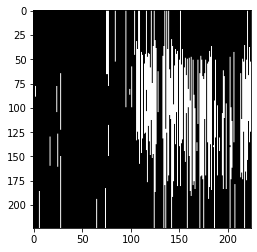

In [0]:
plt.imshow(x_train[190])
plt.show()

## By top k


In [0]:
f =  h5py.File('My Drive/Stethoscope/whole_data.hdf5', "r+")

specs_h5 = np.array(f["specs"]).astype("float32")
sonotypes_h5 = np.array(f["sonotypes"])
times_h5 = np.array(f["times"]).astype("float32")
freqs_h5 = np.array(f["freqs"]).astype("float32")
# groups_h5 = np.array(f["groups"])

f.close()

In [0]:
# append x_times an x_freqs to be auxiliary_input
aux_input_h5 = np.append(times_h5,freqs_h5, axis = 1)

print(aux_input_h5.shape)
print(aux_input_h5[10])

(2881, 4)
[22293.    22321.469  7993.379  8626.394]


In [0]:
# create the dictionary for sonotypes and groups
sono2group = dict(zip(sonotypes_h5,groups_h5))

# get the data for top k sonotypes
s_unique, s_freq = np.unique(sonotypes_h5,return_counts=True)
s_freq_order = np.argsort(s_freq)[::-1]
s_freq_desc = s_freq[s_freq_order]

print(s_unique[s_freq_order][:10])
print(s_freq_desc[:10])

[ 52. 138.  25. 463. 236.   1.  86. 139. 220.  90.]
[142 120 113  92  72  69  57  45  43  40]


##### use a balanced set of input


In [0]:
numUsed =2
groupUsed = b'b' # use bird for now
typeUsed = []
min_num = 1000

typeUsed=[52,138]
min_num = 120
# index = 0
# while len(typeUsed) < numUsed:
#   cur_type = s_unique[s_freq_order][index]
#   if sono2group[cur_type] == groupUsed:
#     typeUsed.append(cur_type)
#     if s_freq_desc[index] < min_num:
#       min_num = s_freq_desc[index]
#   index += 1

print(typeUsed)
print(min_num)
# typeUsed = s_unique[s_freq_order][:numUsed]
# min_num = s_freq_desc[numUsed -1] # the number of every sonoytpes

specs = []
aux_input = []
sonotypes = []

for i in range(numUsed):
  # get index of the current type of spec
  cur_index = np.argwhere(sonotypes_h5 == typeUsed[i]).flatten()
  # randomly choose index in b 
  # to ensure we have same number of type b and i
  random.shuffle(cur_index)
  cur_index_resized = cur_index[:min_num]
  if len(specs):
    specs = np.append(specs, specs_h5[cur_index_resized], axis = 0)
  else:
    specs = specs_h5[cur_index_resized]

  if len(aux_input):
    aux_input = np.append(aux_input, aux_input_h5[cur_index_resized], axis= 0)
  else:
    aux_input = aux_input_h5[cur_index_resized]
  
  if len(sonotypes):
    sonotypes = np.append(sonotypes, np.repeat(i, min_num))
  else:
    sonotypes = np.repeat(i, min_num)

print(specs.shape)
print(aux_input.shape)
# print(sonotypes)

[52, 138]
120
(240, 224, 224, 3)
(240, 4)


#### use a inbalanced set of input

In [0]:
numUsed = 4
typeUsed = s_unique[s_freq_order][:numUsed]
# min_num = s_freq_desc[numUsed -1] # the number of every sonoytpes

specs = []
aux_input = []
sonotypes = []

for i in range(numUsed):
  # get index of the current type of spec
  cur_index = np.argwhere(sonotypes_h5 == typeUsed[i]).flatten()
  # randomly choose index in b 
  # to ensure we have same number of type b and i
  # random.shuffle(cur_index)
  # cur_index_resized = cur_index[:min_num]
  if len(specs):
    specs = np.append(specs, specs_h5[cur_index], axis = 0)
  else:
    specs = specs_h5[cur_index]

  if len(aux_input):
    aux_input = np.append(aux_input, aux_input_h5[cur_index], axis= 0)
  else:
    aux_input = aux_input_h5[cur_index]
  
  if len(sonotypes):
    sonotypes = np.append(sonotypes, np.repeat(i, len(cur_index)))
  else:
    sonotypes = np.repeat(i,len(cur_index))

print(specs.shape)
print(aux_input.shape)
# print(sonotypes)

(467, 224, 224, 3)
(467, 4)


#### thresholding for spectrogram

In [0]:
#  use threshold to get rid of small data
for i in range(len(specs)):
  threshold = np.percentile(specs[i], 80)
  specs[i] = np.where(specs[i] < threshold, 0, 255)

## Seperate test and train

In [0]:
# seperate the data into training and testing
x_train, x_test, y_train, y_test, aux_train, aux_test = train_test_split(specs, sonotypes, aux_input,test_size=0.1)

# work without aux input
aux_train = np.zeros((len(x_train), 4))
aux_test = np.zeros((len(x_test),4))

print(len(x_train))
print(len(x_test))

216
24


#Test with MINST dataset

In [0]:
from keras.datasets.mnist import load_data
import cv2

types = [1,5,4,3,2]
num = [72,72,72,72,72]
# load the data - it returns 2 tuples of digits & labels - one for
# the train set & the other for the test set
(train_digits, train_labels), (test_digits, test_labels) = load_data()

train_num = np.multiply(num, 0.9)
test_num = np.multiply(num, 0.1)

# re-shape the images data
train_data = []
test_data = []
train_y = []
test_y = []
for j in range(len(types)):
  cur_train = []
  for i in range(len(train_digits)):
    if train_labels[i] == types[j]:
      spec_resized=cv2.resize(train_digits[i],(224,224))
      spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64 
      spec_resized = np.flip(spec_resized,0)
      cur_train.append(spec_resized)
      train_y.append(train_labels[i])
    if len(cur_train) >= train_num[j]:
      if len(train_data):
        train_data = np.append(train_data, cur_train, axis = 0)
      else:
        train_data = cur_train
      break
  

  cur_test = []
  for i in range(len(test_digits)):
    if test_labels[i] == types[j]:
      spec_resized=cv2.resize(test_digits[i],(224,224))
      spec_resized=cv2.cvtColor(spec_resized.astype('float32'), cv2.COLOR_BGR2RGB) #cv2 does not accept float64 
      spec_resized = np.flip(spec_resized,0)
      cur_test.append(spec_resized)
      test_y.append(test_labels[i])
    if len(cur_test) >= test_num[j]:
      if len(test_data):
        test_data = np.append(test_data, cur_test, axis = 0)
      else:
        test_data = cur_test
      break

train_digits = []
train_labels = []
test_digits = []
test_labels = []

In [0]:
len(train_data), len(test_data)

(325, 40)

In [0]:
from keras.utils import to_categorical

cat_y_train = to_categorical(train_y[:1600])
cat_y_test = to_categorical(test_y[:200])
aux_train = np.zeros((len(train_data), 4))
aux_test = np.zeros((len(test_data),4))
x_train = train_data
x_test = test_data

len(aux_train), len(aux_test)

(325, 40)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


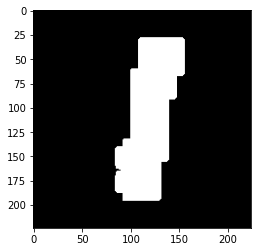

In [0]:
plt.imshow(x_train[1])
print(train_y[1])
plt.show()

#To Categorical

In [0]:
# Convert labels to a categorical array
# currently 492 classes for trainning set and 490 tests for test class

# cat_y_test = to_categorical(y_test, num_classes = 500)
# cat_y_train = to_categorical(y_train, num_classes = 500)

# if use groups
num_c = max(len(np.unique(y_test)), len(np.unique(y_train)))
print(num_c)
cat_y_test = to_categorical(pd.factorize(y_test)[0],num_classes= num_c)
cat_y_train = to_categorical(pd.factorize(y_train)[0], num_classes= num_c)

2


#Model


In [0]:
config = dict(
    dropout = 0.55,
    hidden = 1024,
    learn_rate = 0.00001,
    epochs = 30,
    )

In [0]:
def build_finetune_model(base_model, dropouts, fc_layers, num_classes):
    #for layer in base_model.layers:
    #    layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    # add input layer
    auxiliary_input = Input(shape=(4,), name='aux_input')
    x = concatenate([x, auxiliary_input])

    for fc, drop in zip(fc_layers, dropouts):
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(drop)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=[base_model.input,auxiliary_input], outputs=predictions)
    # finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

model = None
keras.backend.clear_session()
model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = build_finetune_model(model, 
                             [config["dropout"], config["dropout"]], 
                             [config["hidden"], config["hidden"]], 
                             cat_y_train.shape[1])

In [0]:
model.summary()

In [0]:
plot_model(model,to_file = 'My Drive/Stethoscope/model.png')

#Training

In [0]:
filepath = 'My Drive/Stethoscope/model_group.hdf5'

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

opt = Adam(lr=config["learn_rate"])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=[x_train, aux_train], y=cat_y_train, validation_data=([x_test, aux_test], cat_y_test), epochs=20)
# history = model.fit(x=[x_train, aux_train], y=cat_y_train, validation_data=([x_test, aux_test], cat_y_test), epochs=config["epochs"], callbacks=[earlystop, checkpoint])

# Data

## With only Birds

###2 types, 120 each
loss: 10.2101 - accuracy: 0.9444 - val_loss: 24.5293 - val_accuracy: 0.9583
###3 types, 92 each
loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.1741 - val_accuracy: 0.9643
loss: 0.0228 - accuracy: 0.9879 - val_loss: 0.7307 - val_accuracy: 0.9286

###4 types, 57 each
accuracy: 0.8683 - val_loss: 2.6672 - val_accuracy: 0.6087

###5 types, 45 each
accuracy: 0.3713 - val_loss: 1.4765 - val_accuracy: 0.4348

## With all the groups





### balanced classes with time and frequency:
###2 types, 120 each
loss: 10.2101 - accuracy: 0.9444 - val_loss: 24.5293 - val_accuracy: 0.9583
###3 types, 113 each
loss: 328.8753 - accuracy: 0.3574 - val_loss: 53.3833 - val_accuracy: 0.4412
###4 types, 92 each
loss: 368.9658 - accuracy: 0.3958 - val_loss: 191.2737 - val_accuracy: 0.3784
###5 types, 72 each
3s 9ms/step - loss: 461.9938 - accuracy: 0.3086 - val_loss: 326.3062 - val_accuracy: 0.1389

##inbalanced classes with time and frequency:
###2 types,
loss: 116.8172 - accuracy: 0.7447 - val_loss: 74.5958 - val_accuracy: 0.8148
###3 types,
loss: 314.5453 - accuracy: 0.3650 - val_loss: 140.8449 - val_accuracy: 0.3421
###4 types,
loss: 560.8641 - accuracy: 0.2405 - val_loss: 157.1247 - val_accuracy: 0.1915

##balanced classes without times and frequency
loss: 9.5630 - accuracy: 0.5463 - val_loss: 3.9478 - val_accuracy: 0.3750
not work

##MINST balanced
###2 types, 120 each
loss: 0.0494 - accuracy: 0.9907 - val_loss: 0.0021 - val_accuracy: 1.0000
###3 types, 113 each
loss: 0.0284 - accuracy: 0.9967 - val_loss: 0.0239 - val_accuracy: 1.0000
###4 =types, 92 each
loss: 0.0589 - accuracy: 0.9849 - val_loss: 0.0161 - val_accuracy: 1.0000
###5 types, 72 each
loss: 0.0930 - accuracy: 0.9723 - val_loss: 0.0757 - val_accuracy: 0.9500


#Model Performance

In [0]:
# model = load_model('My Drive/Stethoscope/model.hdf5')
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

print(history)
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19
[[0.38693503 0.613065  ]]


Text(0.5, 1.0, '\nPrediction: [1]\nActual: [1]\nConfidence: 61.30%')

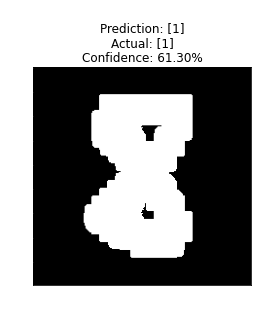

In [0]:
# prediction
%matplotlib inline
randIdx = random.randint(0,len(x_test)-1)
print(randIdx)
test_img = x_test[randIdx]
test_aux = aux_test[randIdx]
confidence = model.predict([np.reshape(test_img,(1,224,224,3)), np.reshape(test_aux, (1,4))])
c  = float(str(confidence[0][np.argmax(confidence)])[:6]);
print(confidence)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# img = plt.imshow(test_img[:,:,1])
img = plt.imshow(test_img)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
title = ('\nPrediction: ' + str([np.argmax(confidence)]) + 
          '\nActual: ' + str([np.argmax(cat_y_test[randIdx])]) +
          '\nConfidence: ' +'{:.2%}'.format(c))
plt.title(title)


#MISC

[[1. 0.]]


Text(0.5, 1.0, '\nPrediction: [0]\nActual: [1]\nConfidence: 100.00%')

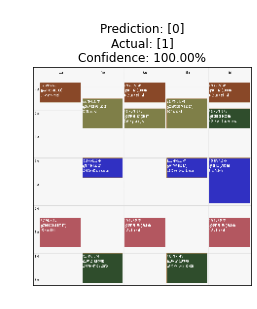

In [0]:
# predit image with pre-trained weight of iamgeNet
import cv2
img_path = "My Drive/Stethoscope/2020Spring.png"
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
test_img = x=cv2.resize(img,(224,224))[:,:,:3]
test_aux = [1000,1000,1000,1009]
confidence = model.predict([np.reshape(test_img,(1,224,224,3)), np.reshape(test_aux, (1,4))])
c  = float(str(confidence[0][np.argmax(confidence)])[:6]);
print(confidence)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# img = plt.imshow(test_img[:,:,1])
img = plt.imshow(test_img)
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
title = ('\nPrediction: ' + str([np.argmax(confidence)]) + 
          '\nActual: ' + str([np.argmax(cat_y_test[randIdx])]) +
          '\nConfidence: ' +'{:.2%}'.format(c))
plt.title(title)
